In [1]:
import pandas as pd
import scipy
from sklearn import *
import re
from SimpleCountVectorizer import *

from nltk.stem import WordNetLemmatizer, SnowballStemmer

In [2]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\perec\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
"""Given an int32 number, print it in English."""
def int_to_en(num):
    d = { 0 : 'zero', 1 : 'one', 2 : 'two', 3 : 'three', 4 : 'four', 5 : 'five',
          6 : 'six', 7 : 'seven', 8 : 'eight', 9 : 'nine', 10 : 'ten',
          11 : 'eleven', 12 : 'twelve', 13 : 'thirteen', 14 : 'fourteen',
          15 : 'fifteen', 16 : 'sixteen', 17 : 'seventeen', 18 : 'eighteen',
          19 : 'nineteen', 20 : 'twenty',
          30 : 'thirty', 40 : 'forty', 50 : 'fifty', 60 : 'sixty',
          70 : 'seventy', 80 : 'eighty', 90 : 'ninety' }
    k = 1000
    m = k * 1000
    b = m * 1000
    t = b * 1000

    assert(0 <= num)

    if (num < 20):
        return d[num]

    if (num < 100):
        if num % 10 == 0: return d[num]
        else: return d[num // 10 * 10] + '-' + d[num % 10]

    if (num < k):
        if num % 100 == 0: return d[num // 100] + ' hundred'
        else: return d[num // 100] + ' hundred and ' + int_to_en(num % 100)

    if (num < m):
        if num % k == 0: return int_to_en(num // k) + ' thousand'
        else: return int_to_en(num // k) + ' thousand, ' + int_to_en(num % k)

    if (num < b):
        if (num % m) == 0: return int_to_en(num // m) + ' million'
        else: return int_to_en(num // m) + ' million, ' + int_to_en(num % m)

    if (num < t):
        if (num % b) == 0: return int_to_en(num // b) + ' billion'
        else: return int_to_en(num // b) + ' billion, ' + int_to_en(num % b)

    if (num % t == 0): return int_to_en(num // t) + ' trillion'
    else: return int_to_en(num // t) + ' trillion, ' + int_to_en(num % t)

    raise AssertionError('num is too large: %s' % str(num))

# Count Vectorizer

In [4]:
train_df = pd.read_csv("../course2020/data/quora_train_data.csv")

train_df, test_df = sklearn.model_selection.train_test_split(train_df, test_size=0.1, random_state=123)

In [5]:
train_df.shape, test_df.shape

((291088, 6), (32344, 6))

In [6]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
311380,370141,108248,500659,How do I get home tutors?,How can I trust a home tutor?,0
62646,400219,349589,66001,"What is the difference between 'had been', 'ha...","When should I use ""has been"", ""have been"" and ...",0
98055,15247,29146,29147,If my ATM card is blocked for online transacti...,My credit card was used for fraud transactions...,0
127437,124101,200474,42953,How do I add USB 3.0 port in a laptop without ...,Can I use a USB 3.0 device in a USB 2.0 port?,0
111569,1333,2657,2658,What is the best Advantage of using Quora?,What is the benefit to Quora?,1


In [7]:
def cast_list_as_strings(mylist):
    """
    return a list of strings
    """
    assert isinstance(mylist, list), f"the input mylist should be a list it is {type(mylist)}"
    
    # return list(map(lambda x: str(x), all_questions)) # Slower
    return [str(s) for s in mylist]

In [8]:
all_questions = cast_list_as_strings(list(train_df.loc[:, 'question1'])+list(train_df.loc[:, 'question2']))
print(set(type(x).__name__ for x in all_questions))

{'str'}


In [9]:
# doc_cleaner_pattern=r"[^a-zA-Z]"
# clean_doc_pattern = re.compile(doc_cleaner_pattern)

In [10]:
def num_conv(s):
    try:
        return int_to_en(int(s)).replace(",","").replace(" ","_")
    except:
        return s


def my_doc_cleaner(doc,
                  pat=r"[^a-zA-Z0-9]"):
    # Allow alphanumeric characters
    doc_cleaner_pattern=pat
    clean_doc_pattern = re.compile(doc_cleaner_pattern)
    doc_clean = clean_doc_pattern.sub(" ", doc)
    return doc.lower()


# stpw = set(stopwords.words("english"))
stpw = []

stemmer =  SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

def my_tokenizer_func(doc, 
                      ngrams=(1,3), 
                      numbers_to_words=True,
                      stop_words=stpw,
                      pat=r"(?u)\b\w\S*\w*\b",
                      lem=True,
                      stem=True):
    
    # Split using a patterm
#     pat=r"(?u)\b\w\w+\b"
#     pat=r"(?u)\b\w\S*\w*\b"
    token_pattern = re.compile(pat)
    lst = token_pattern.findall(doc)
    
    # Transform numbers into words
    if numbers_to_words:
        lst = list(map(lambda x: num_conv(x), lst))
        
    # Drop stopwords 
    lst = list(filter(lambda x : x not in stop_words, lst))
    
    #Stemmer
    if stem:
        lst = list(map(lambda x: stemmer.stem(x), lst))
    
    #Lemmatizer 
    if lem:
        lst = list(map(lambda x: lemmatizer.lemmatize(x), lst))
        
    if ngrams==(1,1):
        return lst
    
    # Generate ngrams
    lstRet = []
    for a in range(ngrams[0], ngrams[1]+1):
        if a!=1:
            lstRet+=list(zip(*[lst[i:] for i in range(a)]))
    return lstRet if ngrams[0]!=1 else lst+lstRet

In [11]:
count_vect = SimpleCountVectorizer(
    doc_cleaner_func=my_doc_cleaner,
    tokenizer_func=my_tokenizer_func
)
count_vect.fit(all_questions)

SimpleCountVectorizer(doc_cleaner_func=<function my_doc_cleaner at 0x000001BD02529828>,
                      doc_cleaner_pattern='[^a-zA-Z]',
                      dtype=<class 'numpy.float32'>, min_word_counts=1,
                      token_pattern='(?u)\\b\\w\\w+\\b',
                      tokenizer_func=<function my_tokenizer_func at 0x000001BD025F45E8>,
                      word_transformer_func=None)

In [12]:
def get_features_from_df(df, count_vectorizer):
    """
    returns a sparse matrix containing the features build by the count vectorizer.
    Each row should contain features from question1 and question2.
    """
    q1_casted =  cast_list_as_strings(list(df["question1"]))
    q2_casted =  cast_list_as_strings(list(df["question2"]))
        
    q1 = count_vectorizer.transform(q1_casted)
    q2 = count_vectorizer.transform(q2_casted)
    
    X_q1q2 = scipy.sparse.hstack((q1,q2))
        
    return X_q1q2

In [13]:
X_tr_q1q2 = get_features_from_df(train_df,count_vect)
X_te_q1q2  = get_features_from_df(test_df, count_vect)

X_tr_q1q2.shape, train_df.shape, test_df.shape, X_te_q1q2.shape

((291088, 5726648), (291088, 6), (32344, 6), (32344, 5726648))

In [14]:
y_train = train_df["is_duplicate"].values

In [15]:
logistic = sklearn.linear_model.LogisticRegression(solver="liblinear", verbose=1, max_iter=100)
%time logistic.fit(X_tr_q1q2, y_train)

[LibLinear]Wall time: 3min 3s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=1,
                   warm_start=False)

In [16]:
def get_mistakes(clf, df, X_q1q2, y):

    predictions = clf.predict(X_q1q2)    
    incorrect_predictions = predictions!=y

    incorrect_indices = np.where(incorrect_predictions)[0]
    
    if np.sum(incorrect_predictions)==0:
        print("no mistakes in this df")
    else:
        return incorrect_indices, predictions
    
def print_mistake_k(k, mistake_indices, predictions):
    print(train_df.iloc[mistake_indices[k]].question1)
    print(train_df.iloc[mistake_indices[k]].question2)
    print("true class:", train_df.iloc[mistake_indices[k]].is_duplicate)
    print("prediction:", predictions[mistake_indices[k]])
    
def print_mistake_k_and_tokens(k, mistake_indices, predictions,
                               X_q1q2, count_vect, clf):
    q1 = train_df.iloc[mistake_indices[k]].question1
    q2 = train_df.iloc[mistake_indices[k]].question2
    
    print(q1)
    print(count_vect.tokenize(q1))
    print()
    print(q2)
    print(count_vect.tokenize(q2))
    print()
    print("true class:", train_df.iloc[mistake_indices[k]].is_duplicate)
    print("prediction:", predictions[mistake_indices[k]])
    print()
    print("Probability vector: [P(0|x), P(1|x)]:")
    print(clf.predict_proba(X_q1q2)[mistake_indices[k],:])
    
    
def hist_errors(mistake_indices, predictions,
                               X_q1q2, count_vect, clf):
    qs = train_df.iloc[mistake_indices][['question1', 'question2']]
    qs['true_class']=train_df.iloc[mistake_indices].is_duplicate
    qs['prediction']=predictions[mistake_indices]
    qs['P(1|x)']=clf.predict_proba(X_q1q2)[mistake_indices,:][:,1]
    qs = qs.reset_index(drop=True)
    return qs


In [17]:
mistake_indices, predictions = get_mistakes(logistic,train_df, X_tr_q1q2, y_train)

In [18]:
"There are {:d}/{:d} ({:5.3f}%) mistakes".format(len(mistake_indices),len(train_df),100*len(mistake_indices)/len(train_df))

'There are 944/291088 (0.324%) mistakes'

In [19]:
print_mistake_k(0, mistake_indices, predictions)

What is the best website to learn coding?
Which is the best website to learn coding in java?
true class: 0
prediction: 1


In [20]:
print_mistake_k_and_tokens(0, mistake_indices, predictions,
                           X_tr_q1q2, count_vect, logistic)

What is the best website to learn coding?
['what', 'is', 'the', 'best', 'websit', 'to', 'learn', 'code', ('what', 'is'), ('is', 'the'), ('the', 'best'), ('best', 'websit'), ('websit', 'to'), ('to', 'learn'), ('learn', 'code'), ('what', 'is', 'the'), ('is', 'the', 'best'), ('the', 'best', 'websit'), ('best', 'websit', 'to'), ('websit', 'to', 'learn'), ('to', 'learn', 'code')]

Which is the best website to learn coding in java?
['which', 'is', 'the', 'best', 'websit', 'to', 'learn', 'code', 'in', 'java', ('which', 'is'), ('is', 'the'), ('the', 'best'), ('best', 'websit'), ('websit', 'to'), ('to', 'learn'), ('learn', 'code'), ('code', 'in'), ('in', 'java'), ('which', 'is', 'the'), ('is', 'the', 'best'), ('the', 'best', 'websit'), ('best', 'websit', 'to'), ('websit', 'to', 'learn'), ('to', 'learn', 'code'), ('learn', 'code', 'in'), ('code', 'in', 'java')]

true class: 0
prediction: 1

Probability vector: [P(0|x), P(1|x)]:
[0.42311168 0.57688832]


In [21]:
qs = hist_errors(mistake_indices, predictions,
                           X_tr_q1q2, count_vect, logistic)
qs.sort_values(by='P(1|x)', ascending=False)

,question1,question2,true_class,prediction,P(1|x)
309,What are the best ways to lose weight?,How can you lose 5 pounds in 2 weeks safely?,0,1,0.938105
169,How do I see who viewed my instagram videos?,Can you see who views your Instagram?,0,1,0.927462
783,Where and how can I find best hotel in Bhopal?,Where can I find best hotel in Bhopal?,0,1,0.899584
219,How do I find a good programmer?,How can I be a good programmer?,0,1,0.883261
636,How can I gain weight in a healthy way?,What are the best way to gain weight?,0,1,0.881951
...,...,...,...,...,...
336,Which are the best and worst Bollywood movies ...,Which is the best and worst Bollywood movie of...,1,0,0.216166
295,Why did you become a data scientist?,How did you become a Data Scientist?,1,0,0.201066
178,Should I become a graphic designer?,Should I be a graphic designer?,1,0,0.194377
349,Why should I not vote for Donald Trump?,Why shouldn't I vote for Donald Trump?,1,0,0.187295


In [24]:
y_test = test_df["is_duplicate"].values

In [25]:
mistake_indices, predictions = get_mistakes(logistic,test_df, X_te_q1q2, y_test)

In [26]:
"There are {:d}/{:d} ({:5.3f}%) mistakes".format(len(mistake_indices),len(train_df),100*len(mistake_indices)/len(train_df))

'There are 6166/291088 (2.118%) mistakes'

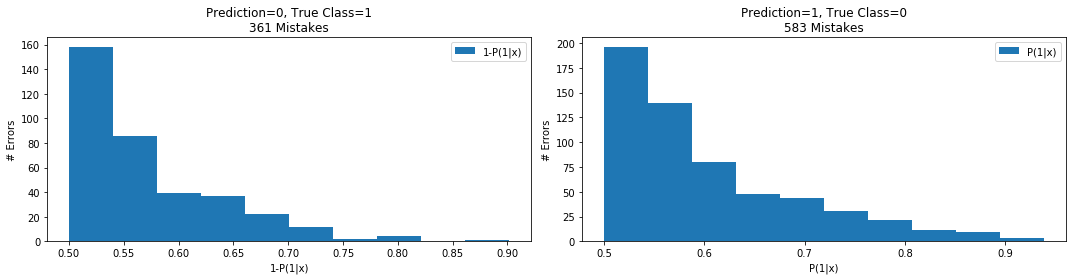

In [192]:
from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(121)

filt = qs.loc[qs['prediction']==0,'P(1|x)']
ax.hist(1-filt, label='1-P(1|x)')
ax.set_title("Prediction=0, True Class=1\n{:d} Mistakes".format(len(filt)))
ax.set_xlabel("1-P(1|x)")
ax.set_ylabel("# Errors")
ax.legend()

ax = fig.add_subplot(122)
ax.hist(qs.loc[qs['prediction']==1,'P(1|x)'], label='P(1|x)')
ax.set_title("Prediction=1, True Class=0\n{:d} Mistakes".format(len(qs)-len(filt)))
ax.set_xlabel("P(1|x)")
ax.set_ylabel("# Errors")
ax.legend()

plt.tight_layout()
plt.show()

# TFIDF